Forecasting series temporales incompletas por Joaquín Amat Rodrigo y Javier Escobar Ortiz, disponible bajo una licencia Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) en https://www.cienciadedatos.net/documentos/py36-forecasting-series-temporales-incompletas.html

In [1]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.0/815.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.0 MB/s eta 0:00:00


En muchos casos reales de forecasting, aunque se disponga de datos históricos, es habitual que las series temporales estén incompletas. La presencia de valores faltantes (missing) en los datos es un problema importante, ya que la mayoría de los algoritmos de forecasting requieren que las series temporales estén completas para poder entrenar un modelo.

Una estrategia comúnmente empleada para evitar este problema consiste en imputar los valores que faltan antes de entrenar el modelo, por ejemplo, utilizando una media móvil. Sin embargo, la calidad de las imputaciones puede no ser buena, lo que perjudica el entrenamiento del modelo. Una forma de mejorar la estrategia de imputación es combinarla con weighted time series forecasting. Esta última consiste en reducir el peso de las observaciones imputadas y, por tanto, su influencia durante el entrenamiento del modelo.

In [2]:
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme

import sklearn
import skforecast
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster

import warnings

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")


Version skforecast: 0.16.0
Version scikit-learn: 1.6.1
Version pandas: 2.2.2
Version numpy: 2.0.2


In [3]:
data = fetch_dataset('bicimad')


bicimad
-------
This dataset contains the daily users of the bicycle rental service (BiciMad) in
the city of Madrid (Spain) from 2014-06-23 to 2022-09-30.
The original data was obtained from: Portal de datos abiertos del Ayuntamiento
de Madrid https://datos.madrid.es/portal/site/egob
Shape of the dataset: (3022, 1)


Se crean valores faltantes

In [4]:
gaps = [
    ['2020-09-01', '2020-10-10'],
    ['2020-11-08', '2020-12-15'],
]

for gap in gaps:
    data.loc[gap[0]:gap[1]] = np.nan

In [5]:
data = data.loc['2020-06-01':'2021-06-01'].copy()
end_train = '2021-03-01'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Fechas train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Fechas test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Fechas train : 2020-06-01 00:00:00 --- 2021-03-01 00:00:00  (n=274)
Fechas test  : 2021-03-01 00:00:00 --- 2021-06-01 00:00:00  (n=93)


<ipython-input-6-57f3c83cb171>:7: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(


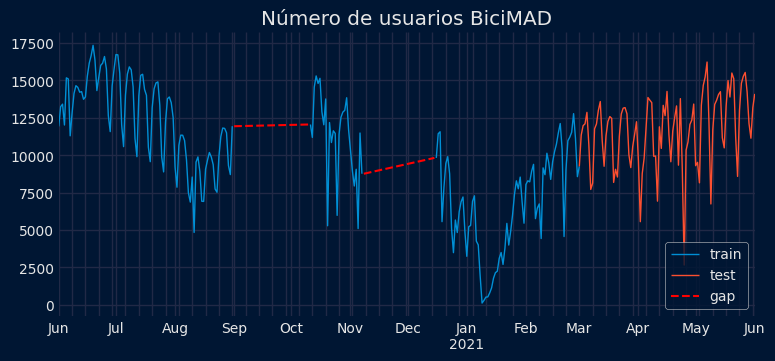

In [6]:
set_dark_theme()
fig, ax = plt.subplots(figsize=(8, 3.5))
data_train.users.plot(ax=ax, label='train', linewidth=1)
data_test.users.plot(ax=ax, label='test', linewidth=1)

for gap in gaps:
    ax.plot(
        [pd.to_datetime(gap[0]), pd.to_datetime(gap[1])],
        [data.users[pd.to_datetime(gap[0]) - pd.Timedelta(days=1)],
         data.users[pd.to_datetime(gap[1]) + pd.Timedelta(days=1)]],
        color = 'red',
        linestyle = '--',
        label = 'gap'
        )

ax.set_title('Número de usuarios BiciMAD')
ax.set_xlabel('')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower right');


In [18]:
data['users_imputed'] = data['users'].interpolate(method='linear')
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]


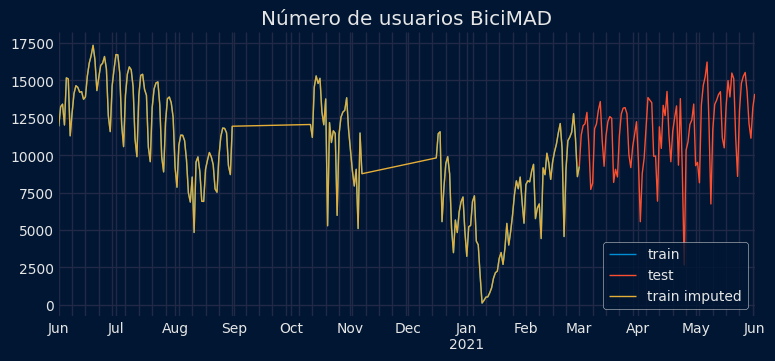

In [19]:
fig, ax = plt.subplots(figsize=(8, 3.5))
data_train.users.plot(ax=ax, label='train', linewidth=1)
data_test.users.plot(ax=ax, label='test', linewidth=1)
data_train.users_imputed.plot(ax=ax, label='train imputed', linewidth=1)
ax.set_title('Número de usuarios BiciMAD')
ax.set_xlabel('')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower right');


In [8]:
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 14
             )

# Backtesting: se predicen en cada iteración 7 días
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 7,
        initial_train_size = len(data.loc[:end_train]),
        refit              = True,
        fixed_train_size   = False
    )
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data.users_imputed,
                            cv         = cv,
                            metric     = 'mean_absolute_error',
                        )
display(metrica)
predicciones.head(4)


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

,mean_absolute_error
0,2151.339364


,pred
2021-03-02,9679.561409
2021-03-03,10556.841280
2021-03-04,8922.423792
2021-03-05,8874.277159


Para minimizar la influencia en el modelo de los valores imputados, se define una función que crea pesos acorde a las siguientes reglas:

Peso de 0 si la fecha del índice al periodo imputado o está a ménos de 14 días de él.

Peso de 1 en caso contrario.

Si una observación tiene un peso de 0, no influye en el entrenamiento del modelo.

✎ Nota

Los valores imputados no deben participar en el proceso de entrenamiento ni como *target* ni como predictor (lags). Por lo tanto, también deben excluirse los valores dentro de una ventana de tamaño tan grande como los lags utilizados.


In [9]:
def custom_weights(index):
    """
    Devuelve 0 si el índice se encuentra en algún gap.
    """
    gaps = [
        ['2020-09-01', '2020-10-10'],
        ['2020-11-08', '2020-12-15'],
    ]

    missing_dates = [pd.date_range(
                        start = pd.to_datetime(gap[0]) + pd.Timedelta('14d'),
                        end   = pd.to_datetime(gap[1]) + pd.Timedelta('14d'),
                        freq  = 'D'
                    ) for gap in gaps]
    missing_dates = pd.DatetimeIndex(np.concatenate(missing_dates))
    weights = np.where(index.isin(missing_dates), 0, 1)

    return weights


In [10]:
forecaster = ForecasterRecursive(
                 regressor   = LGBMRegressor(random_state=123, verbose=-1),
                 lags        = 14,
                 weight_func = custom_weights
             )

# Backtesting: se predicen en cada iteración 7 días
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data.users_imputed,
                            cv         = cv,
                            metric     = 'mean_absolute_error',
                        )
display(metrica)
predicciones.head(4)

  0%|          | 0/14 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

,mean_absolute_error
0,1904.830714


,pred
2021-03-02,10524.159747
2021-03-03,10087.283682
2021-03-04,8882.926166
2021-03-05,9474.810215


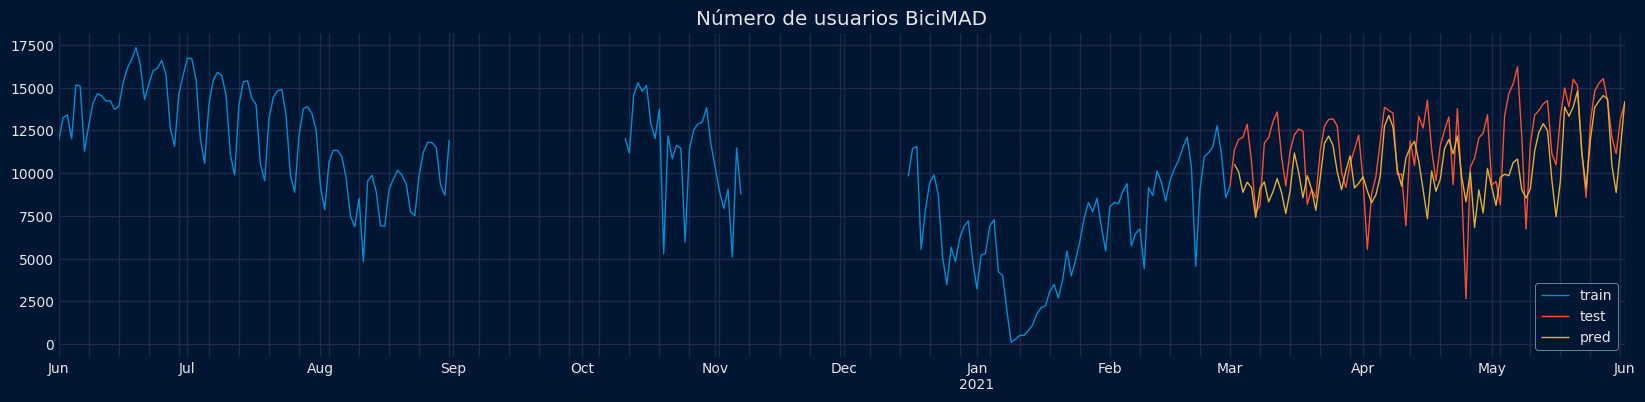

In [22]:
fig, ax = plt.subplots(figsize=(18, 4))
data_train.users.plot(ax=ax, label='train', linewidth=1)
data_test.users.plot(ax=ax, label='test', linewidth=1)
predicciones.plot(ax=ax, label='predicciones', linewidth=1)
ax.set_title('Número de usuarios BiciMAD')
ax.set_xlabel('')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower right');